In [1]:
# Initial imports
import pandas as pd
import hvplot.pandas
from sklearn.linear_model import LinearRegression
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import skew
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from bokeh.models import Legend, LegendItem


train_path = 'Resources/train.csv'
test_path = 'Resources/test.csv'
trained_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)


In [2]:
from pyspark.sql import SparkSession
# Create a Spark session
spark = SparkSession.builder \
    .appName("YourAppNameHere") \
    .getOrCreate()

# Load the training and test data as Spark DataFrames
train_path = 'Resources/train.csv'
test_path = 'Resources/test.csv'

# You can specify the format and options if needed
train_data = spark.read.csv(train_path, header=True, inferSchema=True)
tested_data = spark.read.csv(test_path, header=True, inferSchema=True)

# You can perform various Spark operations on these DataFrames
# For example, to display the first few rows of the training data
train_data.show()



+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

In [3]:
tested_data.show()

+----+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+
|  Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgTy

In [4]:
print(trained_data.columns)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
trained_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
columns_to_remove = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType', 'Alley']

In [7]:
X = trained_data.copy()
X = X.loc[(X['YrSold'] >= 2006) & (X['YrSold'] <= 2010)] #not necessary, the dataset is already 2006-2010
X.drop(columns=columns_to_remove, inplace=True, axis=1)
Xf = X.dropna()
Xf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [8]:
dummies = pd.get_dummies(Xf, columns=['MSZoning','LotConfig','LotFrontage','Street','LotShape','LandContour',
                       'Utilities','LandContour','LandSlope','Neighborhood',
                       'Condition1','Condition2','BldgType','HouseStyle','SaleType','RoofStyle',
                      'RoofMatl','Exterior1st','Exterior2nd','ExterQual','ExterCond',
                      'Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1',
                        'BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual',
                 'Functional','GarageType','GarageFinish','GarageQual',
                  'GarageCond','PavedDrive','SaleType','SaleCondition'], dtype=float)
dummies

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1456,1457,20,13175,6,6,1978,1988,119.0,790,163,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1457,1458,70,9042,7,9,1941,2006,0.0,275,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1458,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
# Define target vector
y = Xf["SalePrice"].ravel()
y[:5]

array([208500, 181500, 223500, 140000, 250000], dtype=int64)

In [10]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(dummies, y, random_state=78)


In [11]:
# Create the StandardScaler instance
scaler = StandardScaler()


In [12]:
# Fit the Standard Scaler with the training data
X_scaler = scaler.fit(X_train)


In [13]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [14]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=500, random_state=78) #500 decision trees putting a vote
rf_model

RandomForestClassifier(n_estimators=500, random_state=78)

In [15]:
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [ ]:
# Get the feature importance array
importances = rf_model.feature_importances_

In [ ]:
# List the top 10 most important features
sorted(zip(rf_model.feature_importances_, X.columns[1:16]), reverse=True)

In [ ]:
# Define the threshold for the minimum count
threshold = 60

# Get value counts of MSSubClass
value_counts = trained_data['MSSubClass'].value_counts()

# Create a dictionary to map values to categories
category_map = {}

# Iterate over the value counts
for value, count in value_counts.items():
    if count >= threshold:
        # Assign specific categories to values based on conditions
        if value == 20:
            category_map[value] = '1-STORY 1946 & NEWER ALL STYLES'
        elif value == 60:
            category_map[value] = '2-STORY 1946 & NEWER'
        elif value == 50:
            category_map[value] = '1-1/2 STORY FINISHED ALL AGES'
        elif value == 120:
            category_map[value] = '1-STORY PUD - 1946 & NEWER'
        elif value == 30:
            category_map[value] = '1-STORY 1945 & OLDER'
        elif value == 160:
            category_map[value] = '2-STORY PUD - 1946 & NEWER'
        elif value == 70:
            category_map[value] = '2-STORY 1945 & OLDER'
    else:
        category_map[value] = 'Other'
        
trained_data['MSSubClass_binned'] = trained_data['MSSubClass'].map(category_map)

In [16]:
trained_data_sorted = trained_data.sort_values(by="MSSubClass", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="MSSubClass",
    y="SalePrice",
    title="Home Sale Price Based on Building Type",
    legend=True,
)
home_sale_plot


:Bars   [MSSubClass]   (SalePrice)

In [17]:
trained_data_sorted = trained_data.sort_values(by="OverallQual", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="OverallQual",
    y="SalePrice",
    title="Home Sale Price Based on Overall Quality"
)
home_sale_plot


:Bars   [OverallQual]   (SalePrice)

In [18]:
trained_data_sorted = trained_data.sort_values(by="Foundation", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Foundation",
    y="SalePrice",
    title="Home Sale Price Based on Foundation"
)
home_sale_plot


:Bars   [Foundation]   (SalePrice)

In [19]:
trained_data_sorted = trained_data.sort_values(by="Condition2", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Condition2",
    y="SalePrice",
    title="Home Sale Price Based on Proximity to various conditions"
)
home_sale_plot


:Bars   [Condition2]   (SalePrice)

In [20]:
trained_data_sorted = trained_data.sort_values(by="LotFrontage", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.scatter(
    x="LotFrontage",
    y="SalePrice",
    title="Home Sale Price Based on Lot"
)
home_sale_plot


:Scatter   [LotFrontage]   (SalePrice)

In [21]:
trained_data_sorted = trained_data.sort_values(by="Condition1", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Condition1",
    y="SalePrice",
    title="Home Sale Price Based on proxmity to main road or railroad"
)
home_sale_plot

#condition 1 and 2 are together basically

:Bars   [Condition1]   (SalePrice)

In [22]:
trained_data_sorted = trained_data.sort_values(by="Neighborhood", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Neighborhood",
    y="SalePrice",
    title="Home Sale Price Based on Neighborhood",
)
home_sale_plot.opts(xrotation=45)

home_sale_plot



:Bars   [Neighborhood]   (SalePrice)

In [23]:
trained_data_sorted = trained_data.sort_values(by="ExterQual", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="ExterQual",
    y="SalePrice",
    title="Home Sale Price Based on Exterior Quality",
)

home_sale_plot


:Bars   [ExterQual]   (SalePrice)

In [24]:
trained_data_sorted = trained_data.sort_values(by="LotShape", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="LotShape",
    y="SalePrice",
    title="Home Sale Price Based on Shape of Property",
)

home_sale_plot


:Bars   [LotShape]   (SalePrice)

In [25]:
trained_data_sorted = trained_data.sort_values(by="LandContour", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="LandContour",
    y="SalePrice",
    title="Home Sale Price Based on Flatness of property",
)

home_sale_plot


:Bars   [LandContour]   (SalePrice)

In [26]:
trained_data_sorted = trained_data.sort_values(by="Heating", ascending=False)

home_sale_plot = trained_data_sorted.hvplot.bar(
    x="Heating",
    y="SalePrice",
    title="Home Sale Price Based on Heating type",
)

home_sale_plot


:Bars   [Heating]   (SalePrice)

------------------------------------------------------------------------------------------------------------------------------

In [27]:
print(trained_data['SalePrice'].describe())


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<Axes: xlabel='SalePrice', ylabel='Count'>

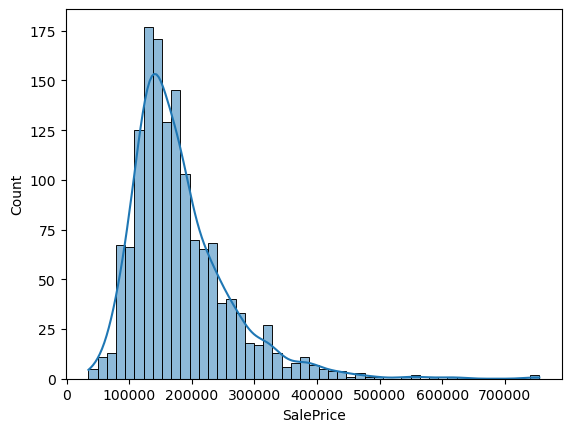

In [28]:
sns.histplot(trained_data['SalePrice'],kde=True)


<Axes: xlabel='SalePrice', ylabel='Count'>

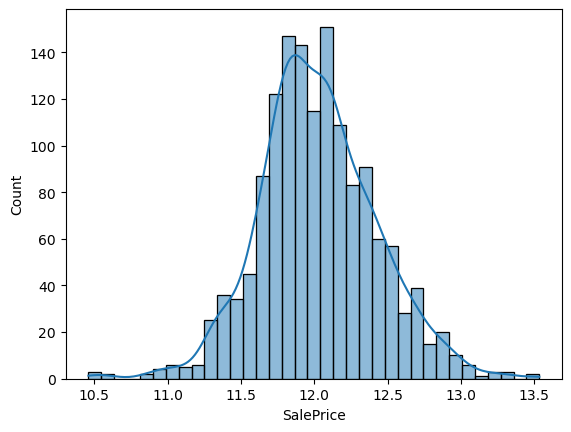

In [29]:
trained_data['SalePrice'] = np.log1p(trained_data['SalePrice'])
sns.histplot(trained_data['SalePrice'],kde=True)

In [30]:
print(f'Train shape : {trained_data.shape}')
print(f'Test shape : {test_data.shape}')

Train shape : (1460, 81)
Test shape : (1459, 80)


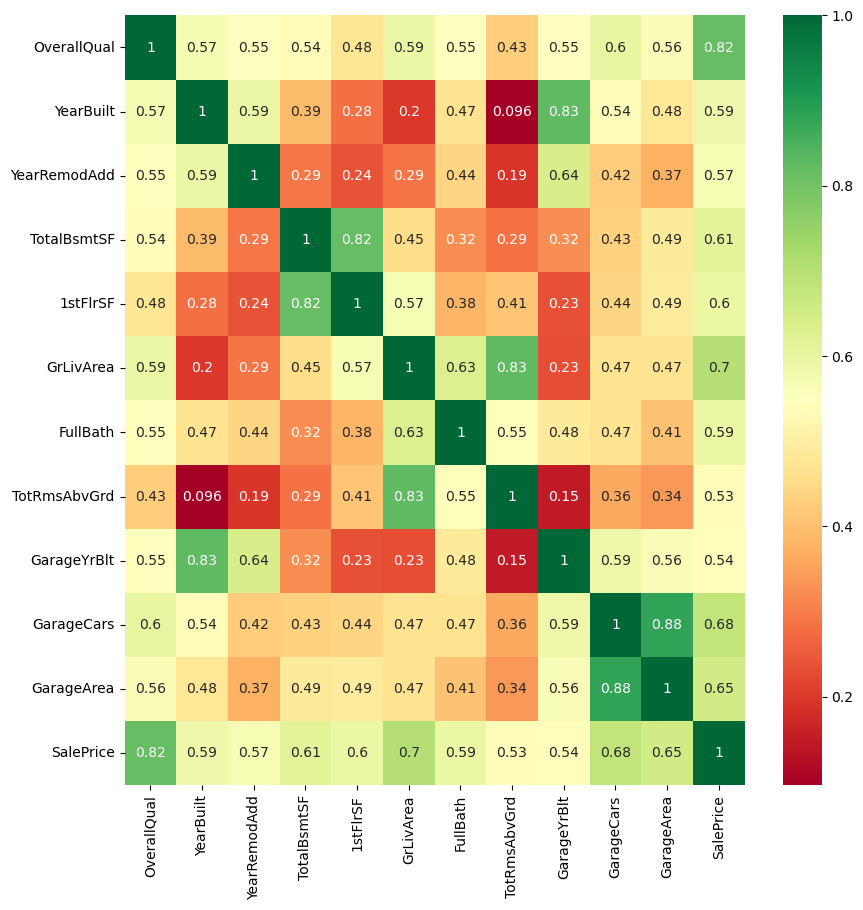

In [31]:
selected_columns = [
    "OverallQual", "YearBuilt", "YearRemodAdd", "TotalBsmtSF",
    "1stFlrSF", "GrLivArea", "FullBath", "TotRmsAbvGrd",
    "GarageYrBlt", "GarageCars", "GarageArea", "SalePrice"] 
#skipped all the categorical values, probably should keep those since this
#influences homesaleprice as shown in the top features
trained_data_corr = trained_data[selected_columns]
corr = trained_data_corr.corr()
highly_corr_features = corr.index[abs(corr["SalePrice"])>0.5]
plt.figure(figsize=(10,10))
map = sns.heatmap(trained_data[highly_corr_features].corr(),annot=True,cmap="RdYlGn")
map.figure.savefig("heatmap.png")

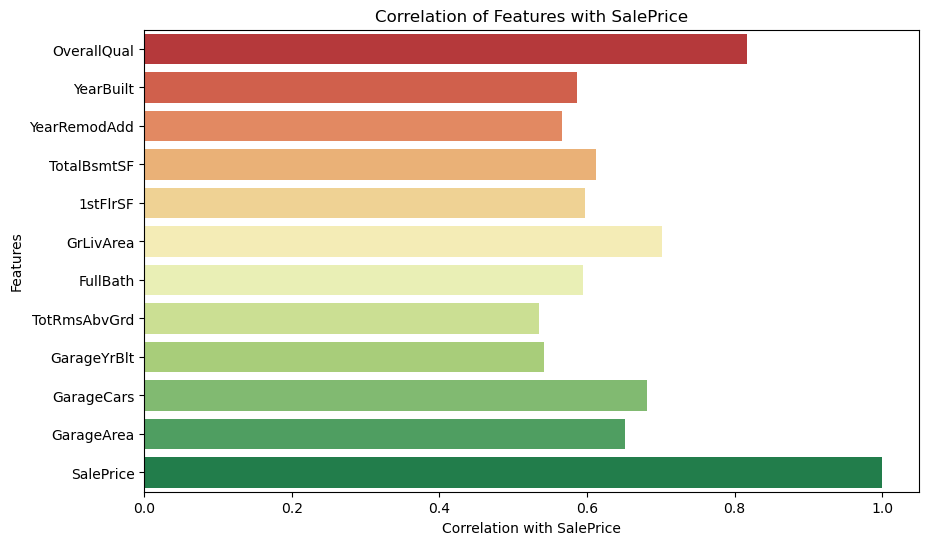

In [32]:
# Extract correlations of each feature with SalePrice
feature_correlations = corr.loc["SalePrice", selected_columns]

# Create a bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_correlations.values, y=feature_correlations.index, palette="RdYlGn")

# Set labels and title
plt.xlabel("Correlation with SalePrice")
plt.ylabel("Features")
plt.title("Correlation of Features with SalePrice")

# Show the plot
plt.show()

In [33]:
numeric_features = trained_data.dtypes[trained_data.dtypes != 'object'].index
numeric_features

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [34]:
corr["SalePrice"].sort_values(ascending=False).head(100)


SalePrice       1.000000
OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
TotRmsAbvGrd    0.534422
Name: SalePrice, dtype: float64

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

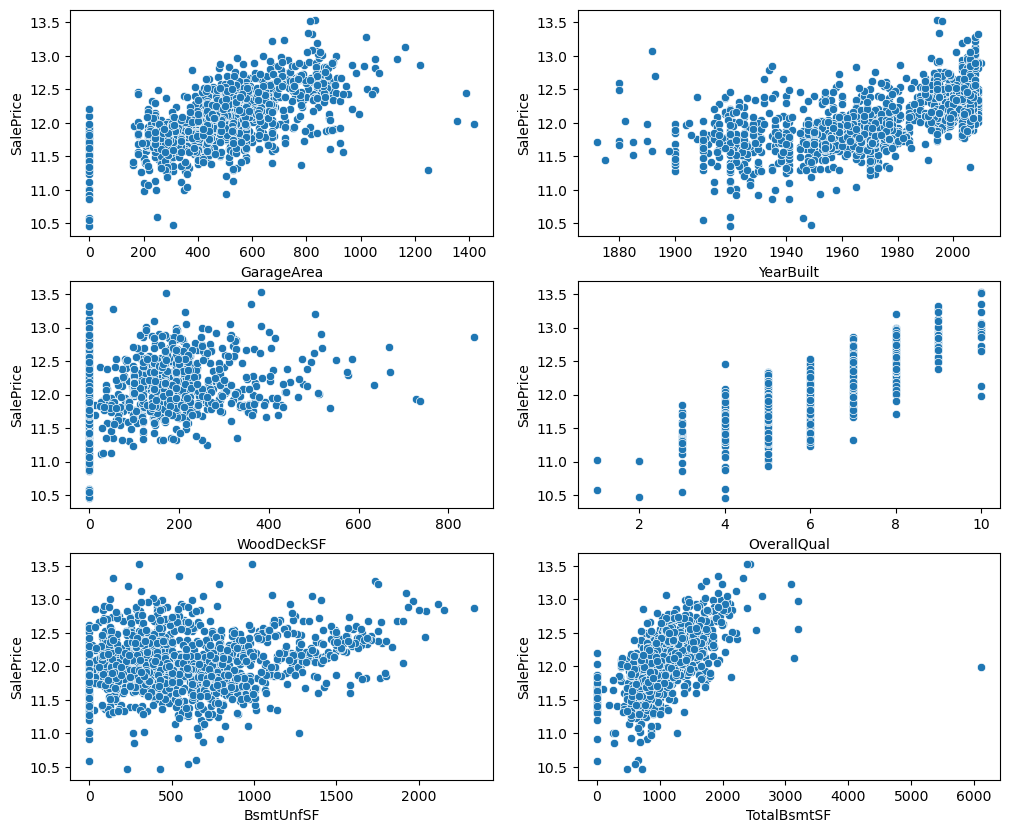

In [35]:
fig = plt.figure(figsize=(12,10))
#GarageArea
plt.subplot(321)
sns.scatterplot(data=trained_data, x='GarageArea', y="SalePrice")
#YearBuilt
plt.subplot(322)
sns.scatterplot(data=trained_data, x='YearBuilt', y="SalePrice")
#WoodDeckSF
plt.subplot(323)
sns.scatterplot(data=trained_data, x='WoodDeckSF', y="SalePrice")
#OverallQual
plt.subplot(324)
sns.scatterplot(data=trained_data, x='OverallQual', y="SalePrice")
#BsmtUnfSF
plt.subplot(325)
sns.scatterplot(data=trained_data, x='BsmtUnfSF', y="SalePrice")
#TotalBsmtSF
plt.subplot(326)
sns.scatterplot(data=trained_data, x='TotalBsmtSF', y="SalePrice")

In [36]:
data = pd.concat([trained_data,test_data], axis=0)
y_train = trained_data['SalePrice']
data = data.drop(['Id', 'SalePrice'], axis=1)
print(data.shape)
print('----------------------------------------------------------------')
print(data.info())

(2919, 79)
----------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 2919 entries, 0 to 1458
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-n

In [37]:
#Columns containing most null values
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum() / data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(missing_data.head(100))

               Total    Percent
PoolQC          2909  99.657417
MiscFeature     2814  96.402878
Alley           2721  93.216855
Fence           2348  80.438506
MasVnrType      1766  60.500171
...              ...        ...
1stFlrSF           0   0.000000
2ndFlrSF           0   0.000000
LowQualFinSF       0   0.000000
GrLivArea          0   0.000000
SaleCondition      0   0.000000

[79 rows x 2 columns]


In [38]:
#Dropping columns with > 5 null values
data.drop((missing_data[missing_data['Total'] > 5]).index, axis=1, inplace=True)
#Sorting columns w.r.t null values
total = data.isnull().sum().sort_values(ascending=False)
total.head(20)

MSZoning        4
Functional      2
BsmtFullBath    2
BsmtHalfBath    2
Utilities       2
BsmtFinSF2      1
Exterior2nd     1
GarageCars      1
GarageArea      1
BsmtFinSF1      1
BsmtUnfSF       1
Exterior1st     1
TotalBsmtSF     1
Electrical      1
SaleType        1
KitchenQual     1
HalfBath        0
FullBath        0
BedroomAbvGr    0
KitchenAbvGr    0
dtype: int64

In [39]:
#Filling the numeric data
numeric_missed = ['BsmtFinSF1',
'BsmtFinSF2',
'BsmtUnfSF',
'TotalBsmtSF',
'BsmtFullBath',
'BsmtHalfBath',
'GarageArea',
'GarageCars']
for feature in numeric_missed:
    data[feature] = data[feature].fillna(0)
#Filling the categorical data
categorical_missed = ['Exterior1st',
'Exterior2nd',
'SaleType',
'MSZoning',
'Electrical',
'KitchenQual',
'Functional']
for feature in categorical_missed:
    data[feature] = data[feature].fillna(data[feature].mode()[0])
#Deleting 'Utilities' column
data.drop(['Utilities'], axis=1, inplace=True)

In [40]:
#Checking for any remaining null values
data.isnull().sum().max()

0

In [41]:
#Top skewed columns
numeric_features = data.dtypes[data.dtypes != 'object'].index
skewed_features = data[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
print(high_skew)

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
YearBuilt        -0.599806
dtype: float64


In [42]:
#Transforming skewed columns
for feature in high_skew.index:
    data[feature] = np.log1p(data[feature])
    
#Converting categorical data to numerical
data = pd.get_dummies(data)
data.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,9.042040,7,1.791759,7.602900,2003,6.561031,0.0,5.017280,6.753438,...,False,False,False,True,False,False,False,False,True,False
1,3.044522,9.169623,6,2.197225,7.589336,1976,6.886532,0.0,5.652489,7.141245,...,False,False,False,True,False,False,False,False,True,False
2,4.110874,9.328212,7,1.791759,7.601902,2002,6.188264,0.0,6.075346,6.825460,...,False,False,False,True,False,False,False,False,True,False
3,4.262680,9.164401,7,1.791759,7.557995,1970,5.379897,0.0,6.293419,6.629363,...,False,False,False,True,True,False,False,False,False,False
4,4.110874,9.565284,8,1.791759,7.601402,2000,6.486161,0.0,6.196444,7.044033,...,False,False,False,True,False,False,False,False,True,False


In [43]:
#Dividing data back into train & test
train=data[:len(y_train)]
test = data[len(y_train):]
#Printing thier shapes
print(train.shape, test.shape)

(1460, 218) (1459, 218)


In [44]:
x_train, x_test, y_train, y_test = train_test_split(train, y_train, test_size=0.2, random_state=42)


In [47]:
clf300 = RandomForestRegressor(n_estimators=300)
clf300.fit(x_train, y_train)
print(f"Regressor score is {clf300.score(x_test,y_test)}")


Regressor score is 0.8901150652157865


In [48]:
clf400 = RandomForestRegressor(n_estimators=400)
clf400.fit(x_train, y_train)
print(f"Regressor score is {clf400.score(x_test,y_test)}")

Regressor score is 0.8869587492451578


In [49]:
clf500 = RandomForestRegressor(n_estimators=500)
clf500.fit(x_train, y_train)
print(f"Regressor score is {clf500.score(x_test,y_test)}")

Regressor score is 0.8873781154306766


In [46]:
#Making a prediction
prediction = clf.predict(x_test)
np.expm1(prediction)
print(prediction)

[11.84551754 12.63834187 11.67170847 11.95183242 12.66837921 11.35078504
 12.27747893 11.93117863 11.35567707 11.76865893 12.00797853 11.71038414
 11.49699883 12.24946234 12.08773292 11.78155408 12.18912476 11.8049691
 11.64443979 12.23968848 11.97320151 12.27973516 12.06633836 11.722097
 12.18561294 12.03658903 12.1228185  11.55379232 12.08394021 12.17577704
 11.7107301  12.45399866 12.01581344 11.63726261 12.45802001 11.85078069
 11.83973923 12.22974086 12.6352858  11.54274231 11.72590798 12.38216517
 11.70593677 12.78706787 11.82446123 11.78523665 11.68078729 11.75948906
 12.86813671 11.87698915 11.71345164 12.14017553 11.6583156  12.68002505
 11.85193715 12.40014307 12.16239305 11.91556982 11.88568709 11.6105373
 11.21104132 11.90353049 12.63096948 12.48490049 12.52381104 12.24487668
 11.59291029 12.67975983 11.65701392 12.01344496 11.76309268 11.8086997
 11.64045928 11.41864563 12.94822056 12.04978354 12.66178318 12.59778866
 11.82661895 11.70456555 11.49464049 11.46105324 11.7255